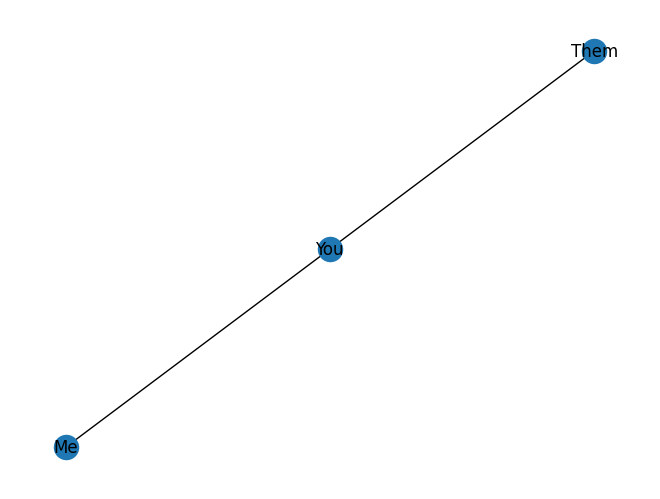

Dr.
Miss
Mx.
Misc.
Mr.
Mrs.
Ms.
Ind.
😟


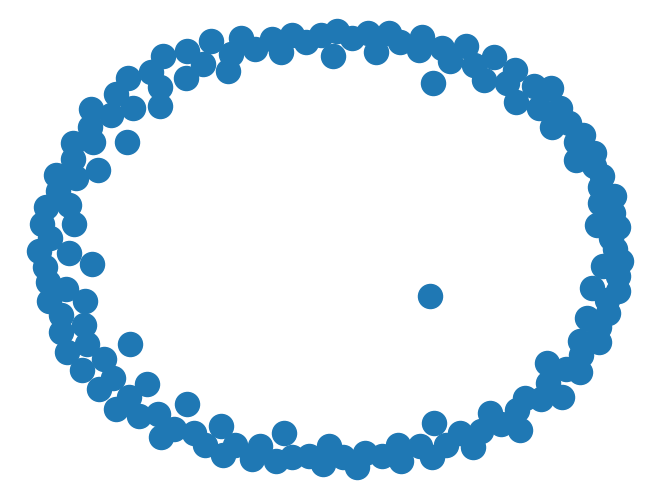

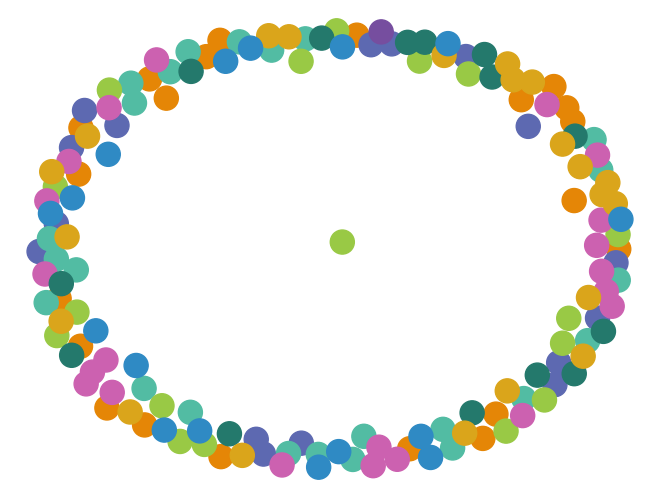

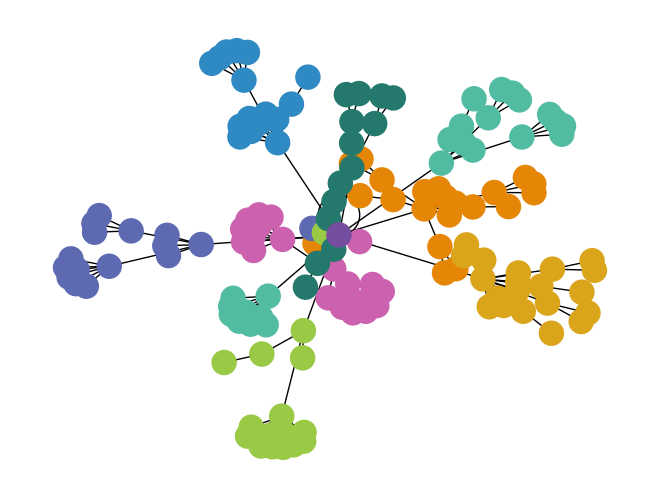

In [1]:
%run "../Part 1 - The Graph/Solution.ipynb"

Now we can take extra info (attributes) of each person (node) and map those onto nodes. This will allow us to connect people *through* common attributes, and not just through relationships like "reporting structure" or "hierarchy"

In [8]:
from itertools import chain
from more_itertools import always_iterable

def add_nodes_from_attributes(G: nx.Graph, *, attribute:str, default=[], flag:str):
    """Find all of the unique values for the given attribute and add those as nodes
    
    Add a flag to that node to make it easy to identify compared to the `people=True` nodes from earlier"""


In [ ]:
add_nodes_from_attributes(G, attribute="languages", flag="language")
add_nodes_from_attributes(G, attribute="city", flag="city")
add_nodes_from_attributes(G, attribute="tz", flag="timezone", default="")

Let's add the edges in now connecting people to the app/language nodes

In [9]:
from more_itertools import always_iterable

def just_people(G):
    """A node filter function, returning only nodes that have the `people="True"` flag"""
    return lambda n: G.nodes()[n].get("person")

In [ ]:
def add_edges_from_attributes(G:nx.Graph, *, attribute:str, weight:int=1):
    """Add edges to the graph connecting people to the attributes they hold"""
    # iterate over all people nodes and connect them to their attribute nodes

In [10]:
add_edges_from_attributes(G, attribute="languages")
add_edges_from_attributes(G, attribute="tz")
add_edges_from_attributes(G, attribute="city")
#add_edges_from_attributes(G, attribute="manager")

This should look interesting! We used a **force-directed layout** to draw the graph, meaning that the edges between nodes are **pulling** the nodes together in order until they find an equilibrium point. This also takes into account the weights we applied to edges, with higher weighed edges behaving like springs with higher spring constants

In [11]:
px_plot_nx(G, height=800, hover_name="label", color="team", size="rank", with_edges=False, template="plotly_dark")

## Finding Communities Programmatically

We can visually look for closeness above, or do it algorithmically... let's try that!

### Ego Graph

Filter down your graph based how nodes are connected (only keep nodes within `radius` hops of your starting node). Try plotting the ego graph for someone in the graph and see how changing the radius between **1, 2, 3** effects the results. Are they meaningful?

In [ ]:
ego = nx.ego_graph(...)

Add this community label as an attribute to the data and plot it again (visualizing the community with `color`). Are they "close" together?

### Node Connectivity

The underlying connectivity information is also easy to recover from the Graph itself. This can be expensive, but try rebuilding the `ego_graph` from the raw pairs of connectivity

In [ ]:
# get all the connections!
connectivity = nx.all_pairs_node_connectivity(...)
ego_again = ...

### Community Detection Algorithms

So far we have used very simple algorithms to look for communities that rely on the structure of the graph instead of any latent information. We don't need to stop there though, let's look at a few [community-detection algorithms](https://networkx.org/documentation/stable/reference/algorithms/community.html) implemented in `networkx.communities`.

For each of these let's detect communities (~5?) and include them on our visualization using a visual indicator like `color` or `shape` 

**Find and plot the louvain communities**

In [ ]:
nx.community.louvain_communities(...)

**Find and plot the fluid communities** 

In [12]:
nx.community.asyn_fluidc(...)

<function networkx.algorithms.community.asyn_fluid.asyn_fluidc(G, k, max_iter=100, seed=None)>

**Find and plot the girvan_newman communities**

In [13]:
nx.community.girvan_newman(...)

<function networkx.algorithms.community.centrality.girvan_newman(G, most_valuable_edge=None)>

### node2vec + clustering

Earlier we leveraged visual representation to find communities (through visual inspection). But this is the same approach (in spirit) to representing a graph as vectors in N-dimensional space (only here we do just 2-dim). A more common approach is to use `node2vec` and then use a clustering algorithm to find communities. This also allows us to add more and more dimensions (for every attribute) and solve using powerful solvers

In [21]:
from sklearn.cluster import SpectralClustering
from node2vec import Node2Vec as n2v

Fit the `node2vec` model to our graph

In [16]:
WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

g_emb = n2v(
  G,
  dimensions=16
)

mdl = g_emb.fit(
    vector_size = 16,
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 15.09it/s]


**Generate the embeddings and store in a DataFrame**

The model now holds the embedded node vectors. We can access them by name

In [28]:
from more_itertools import first
someone = first(G.nodes())
print(someone)
mdl.wv.get_vector(someone)

Gilbert Martinez


array([ 0.41310647,  0.10507037,  0.706437  ,  0.23896855,  0.38805634,
       -0.1080106 ,  1.2754133 ,  0.44740248, -0.32224908,  0.04588044,
        0.49981475, -0.14702491,  0.30804527,  0.444171  ,  0.22604516,
       -0.36677757], dtype=float32)

In [29]:
embeddings_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(name) for name in G.nodes()],
        index = G.nodes
    )
)

And cluster the data

In [30]:
X = emb_df.values

clustering = SpectralClustering(
    n_clusters=5, 
    assign_labels='discretize',
    random_state=0
).fit(X)

clustering

SpectralClustering(assign_labels='discretize', n_clusters=5, random_state=0)

We can now extract the communities and visualize them

In [31]:
communities = dict(zip(emb_df.index, clustering.labels_))

In [33]:
# visualize ...